# Homework for statistics module

Rules for code style:
* All the code in this notebook
* Imports are provided in the head of the notebook
* All the cells could be ran in the right order from the top to the bottom
* Commentaries are required
* All the plots should have: title, axis labels and summaries (if necessary)
* Main summaries are provided in cells using markdown **(your analysis of the results and data is very important!!!)**
* Try to use functions and classes to reduce duplicated code blocks to minimum

Also you can use $\LaTeX$ to write formulas. F.e. $\bar{y} = \frac{1}{n}\sum_{i=1}^n \hat{x}_i$ or on a new line:
$$
    \bar{y} = \frac{1}{n}\sum_{i=1}^n \hat{x}_i
$$
To do so, you can write anything between $\$ \quad \$$ (or  $ \$\$ \quad\$\$ $).

### Criteria (50 points total):
* Task 1 (17 points)

    * Requested formulas are provided - 4 points
    * All necessary experiments are done - 6 points
    * Results are analysed with commentaries - 7 points
* Tasks 2.1 и 2.2 (16 points)

    * Visualization and/or simple exploratory data analysis are implemented - 2 points
    * Hypotheses are tested - 2 points
    * Results are analysed with commentaries - 4 points
* Task 3 (13 points)

    * Visualization and/or simple exploratory data analysis are implemented - 2 points
    * Hypotheses are tested - 4 points
    * Data was aggregated properly - 2 points
    * Results are analysed with commentaries - 5 points
* Extra points:

    * 4 points in case clear, "pythonic" and understandable code style.

Good work: 40+ points.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('bmh')
sns.set(style="darkgrid")

from pylab import rcParams

# plots in svg look more precise
%config InlineBackend.figure_format = 'svg'

from scipy.stats import pearsonr,spearmanr,chi2_contingency,chi2, ttest_ind, levene,kstest,kruskal
import warnings
warnings. filterwarnings(action="ignore") 

# Task 1

## Stratification

The example:

Let's assume, we need to estimate a mean votes count for every election candidate. Suppose there are 3 cities in a country: 1 million factory workers live in city A, 2 million office workers live in city B, and 3 million senior citizens live in city B. We can choose a random sample of 60 votes from the entire population, but there is some chance that the random sample will be poorly balanced between these cities and, therefore, will be biased and of little use ("average temperature in the hospital"), causing a significant error in the estimation. Instead, if we choose to use a simple random sample of 10, 20 and 30 votes from cities A, B and C, respectively, we can get a smaller error in the estimate with the same total sample size. This technique is called stratification.


### The task

Suppose the population is a mixture of 3 normally distributed CBs. In other words, the population can be divided into 3 strata.
$$
    F(X) = a_1 F(X_1) + a_2 F(X_2) + a_3 F(X_3)
$$

**Goals:**  

1. Derive (for example, in the block below, using Markdown) the formulas for point estimates of the mathematical expectation and variance for the average value of subsamples formed in different ways:
- random selection from the entire population;
- random selection of strata in proportion to strata volumes;
- random selection according to the optimal sub-sampling.

2. Calculate point estimates of the mathematical expectation and variance of the mean value for each data sampling method from p.1, provided:
* Experiments should be conducted for 3 cases (for every method from p.1 each):
     * all strata have the same mat. expectations and variance;
     * strata have different mat. expectations, but the same variance;
     * strata have different mat. expectations and variance.
* For each sampling method plot histogram of General Population data (using matplotlib or seaborn packages);
* Plot boxplots for sample mean estimated using each sampling method on a single figure to compare the results. Repeat for each experiment.
* You are provided with `GeneralPopulation` class. It already has all necessary methods for sampling and creating general population as a mixture of strata.
* Your goal is to write functions to conduct experiments and visualize the results.   
* Also provide commentaries as summaries and analysis of results after each visualization.


## Solution for Task 1

### Formulas:

$\hat{\mu}_{k} = \bar{x}_{k} = \frac{1}{n_{k}} \sum_{i=1}^{n_{k}} x_{i_{k}}$  
<br>
$\sigma_{k} = \frac{1}{n_{k}} \sum_{i=1}^{n_{k}} (x_{i_{k}}-\bar{x}_{k})^2$ 
<br><br>
where $k$ = *1,2,3*

$N$ - volume of general population, $N_{1} + N_{2} + N_{3} = N$ - populations of stratas, $a_{k} = \frac{N_{k}}{N}$ - strata's ratio, $n_{1}, n_{2}, n_{3}$ - volume of samples from each strata

#### Stratified sample point estimations:

$\hat{\mu} = \bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_{i} = \sum_{k=1}^{3} a_{k}\bar{x}_{k} = \sum_{k=1}^{3} a_{k}\hat{\mu}_{k} $
<br><br>
$Var(\hat{\mu}) =  \sum_{k=1}^{3} a_{k}^2 Var(\bar{x}_{k}) = \sum_{k=1}^{3} a_{k}^2 \frac{\sigma_{k}^2}{n_{k}} $ 

#### Sample volumes if they are sampled proportionally:

$n_{k} = a_{k}*N$ 

#### Sample volumes if they are optimal sampled (Neyman's method):

$n_{k} = N* \frac{a_{k}\sigma_{k}}{\sum_{k=1}^3 a_{k}\sigma_{k}}$

**GeneralPopulation class**  
Already has methods for creating general population as a mixture of strata, for generating subsample with random, optimal and stratified techniques:

In [2]:
class GeneralPopulation:

    def __init__(self, 
               means: [float], 
               stds: [float], 
               sizes: [int], 
               random_state: int = 15
               ):
        """
        Initializes our General Population and saves the given distributions

        :param means: List of expectations for normal distributions
        :param stds: List of standard deviations for normal distributions
        :param sizes: How many objects will be in each strata
        :param random_state: Parameter fixing randomness. Needed so that when conducting
        experiment repeatedly with the same input parameters, the results remained the same
        """
        self.strats = [st.norm(mean, std) for mean, std in zip(means, stds)]
        self._sample(sizes)
        self.random_state = random_state


    def _sample(self, sizes):
        """Creates a general population sample as a mixture of strata
        
        :param sizes: List with sample sizes of the corresponding normal distributions
        """
        self.strats_samples = [rv.rvs(size) for rv, size in zip(self.strats, sizes)]
        self.general_samples = np.hstack(self.strats_samples)
        self.N = self.general_samples.shape[0]
        
        # number of strata
        self.count_strats = len(sizes)
        
        # ratios for every strata in GP
        self.ws = [size/self.N for size in sizes]
        
        # ME and Std for GP
        self.m = np.mean(self.general_samples)
        self.sigma = np.std(self.general_samples)
        
        # ME and std for all strata
        self.ms = [np.mean(strat_sample) for strat_sample in self.strats_samples]
        self.sigmas = [np.std(strat_sample) for strat_sample in self.strats_samples]


    def random_subsampling(self, size):
        """Creates a random subset of the entire population
        
        :param sizes: subsample size
        """
        rc = np.random.choice(self.general_samples, size=size) 
        return rc
      

    def proportional_subsampling(self, size):
        """Creates a subsample with the number of elements, proportional shares of strata
        
        :param sizes: subsample size
        """
        self.strats_size_proport = [int(np.floor(size*w)) for w in self.ws]
        
        rc = []
        for k in range(len(self.strats_size_proport)):
            rc.append(np.random.choice(self.strats_samples[k],
                                       size=self.strats_size_proport[k]))
        return rc
      

    def optimal_subsampling(self, size):
        """Creates a subsample with the optimal number of elements relative to strata
        
        :param sizes: subsample size
        """
        sum_denom = 0
        for k in range(self.count_strats):
            sum_denom += self.ws[k] * self.sigmas[k]
        self.strats_size_optimal = [int(np.floor((size*w*sigma)/sum_denom)) for w, sigma in zip(self.ws, self.sigmas)]
        if 0 in self.strats_size_optimal:
            raise ValueError('Strats size is 0, please change variance of smallest strat!')
        
        rc = []
        for k in range(len(self.strats_size_optimal)):
            rc.append(np.random.choice(self.strats_samples[k],
                                       size=self.strats_size_optimal[k]))
        return rc   
    
    def run_experiments(self, n_sub, subsampling_method, n_experiments=1000):
        """Conducts a series of experiments and saves the results
        
        :param subsampling_method: method for creating a subsample
        :param n_experiments: number of experiment starts
        """
        means_s = []
        
        if(len(self.general_samples)<100):
            n_sub = 20
            
        if(subsampling_method == 'random_subsampling'):
            for n in range(n_experiments):
                rc = self.random_subsampling(n_sub)
                
                mean = rc.sum()/len(rc)
                means_s.append(mean)
                
        else:
            for n in range(n_experiments):
                if(subsampling_method == 'proportional_subsampling'):
                    rc = self.proportional_subsampling(n_sub)
                elif(subsampling_method == 'optimal_subsampling'):
                    rc = self.optimal_subsampling(n_sub)
                    
                strats_mean = []
                
                for k in range(len(rc)):
                    strats_mean.append(sum(rc[k])/len(rc[k]))
      
                # Mean for a mixture
                means_s.append(sum([w_k*mean_k for w_k, mean_k in zip(self.ws, strats_mean)]))
        
        return means_s

Function for histogram plot:

In [3]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Uses matplotlib or seaborn packages to plot distribution for general population;
* Don't forget a title, grid etc. 
"""
def plot_hist(gp):
    sns.histplot(data=gp.general_samples, kde=True).set_title('Distribution of general population')

Function for plotting Boxplots for sample mean:

In [4]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Runs method `run_experiments` for each sampling method and gets vector of mean values;
* Uses matplotlib or seaborn packages to plot boxplots of mean values for each subsampling techniques;
* Axis Y == Mean values; Axis X == subsampling methods;
* Don't forget a title, grid etc. 
"""

def plot_boxplot(gp):
    
    data1 = gp.run_experiments(N_SUBSAMPLE, "random_subsampling")
    data2 = gp.run_experiments(N_SUBSAMPLE, "proportional_subsampling")
    data3 = gp.run_experiments(N_SUBSAMPLE, "optimal_subsampling")
    data = [data1,data2,data3]
    
    # plt.figure(figsize=(9,6))
    plot = sns.boxplot(data=data)
    plot.set_xlabel( "subsampling methods", size=12) 
    plot.set_ylabel( "Mean values", size=12) 
    plot.set_title( "Boxplots for sample mean")
    plot.set_xticklabels(['random','proportional','optimal'] )


In [5]:
def estimators(gp):  
    """
    Calculating point estimators
    """
    # gp.ms and gp.sigmas are wrong here - should be means and sigmas of samples from strata, not of stratas themselves, 
    # but I couldn't find/count them in time
    
    print('Type: EV | Var')
    # random 
    print('Random: ',
          sum(np.array(gp.ms)*np.array([1/3,1/3,1/3])).round(5), " | ", 
          sum(np.array(gp.sigmas)**2*np.array([1/3,1/3,1/3])**2*np.array([50,50,50])**float(-1)).round(5))
    # proportional
    print('Proportional: ',
          sum(np.array(gp.ms)*np.array([1/3,1/3,1/3])).round(5), " | ", 
          sum(np.array(gp.sigmas)**2*np.array([1/3,1/3,1/3])**2*np.array(gp.strats_size_proport)**float(-1)).round(5))
    # optimal
    print('Optimal: ',
          sum(np.array(gp.ms)*np.array([1/3,1/3,1/3])).round(5), " | ", 
          sum(np.array(gp.sigmas)**2*np.array([1/3,1/3,1/3])**2*np.array(gp.strats_size_optimal)**float(-1)).round(5))


**Parameters for each General Population**  
You can use these or specify your own parameters for strata:

In [6]:
SIZES = (150, 150, 150)
N_SUBSAMPLE = 150
EQUAL_MEAN_EQUAL_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 3, 3], 'sizes': SIZES}
DIFFERENT_MEAN_EQUAL_STDS_ARGS = {'means': [15, -1, -17], 'stds': [3, 3, 3], 'sizes':SIZES}
# EQUAL_MEAN_DIFFERENT_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 7, 11], 'sizes':SIZES}
DIFFERENT_MEAN_DIFFERENT_STDS_ARGS = {'means': [15, -1, -17], 'stds': [3, 8, 15], 'sizes':SIZES}

**Initialization**

In [7]:
# Create GeneralPopulation class instances here
gp1 = GeneralPopulation(means = [0, 0, 0], stds = [3, 3, 3], sizes = SIZES)
gp2 = GeneralPopulation(means = [15, -1, -17], stds = [3, 3, 3], sizes = SIZES)
gp3 = GeneralPopulation(means = [15, -1, -17], stds = [3, 8, 15], sizes = SIZES)

**General population with EQUAL means and EQUAL STDs of strata**  
Distribution histogram:

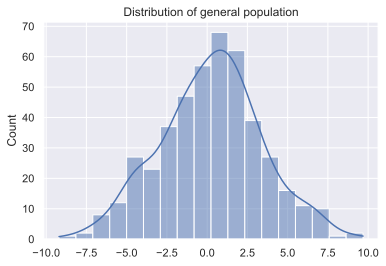

In [8]:
# Run plotting for density
plot_hist(gp1)

A symmetrical distribution, similar to normal - this is due to equality of parameters.

Boxplots for sample mean:

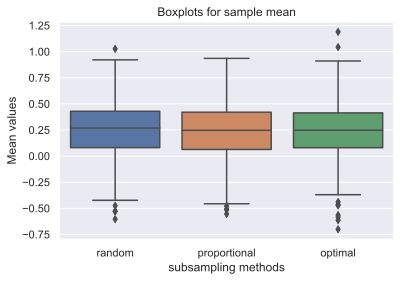

In [9]:
# Run plotting for boxplots
plot_boxplot(gp1)

In [10]:
# estimators(gp1)

There's no significant difference between those three sampling methods with such general population.

**General population with DIFFERENT means and EQUAL STDs of strata**  
Distribution histogram:

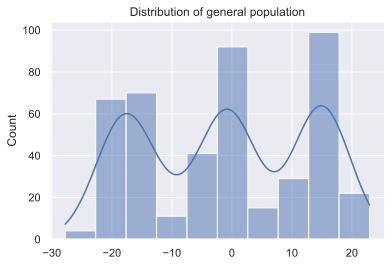

In [11]:
# Run plotting for density
plot_hist(gp2)

We can see three peaks which is caused by the three different means of our stratas, and they are very similar, due to equal standardard deviations of the stratas.

Boxplots for sample mean:

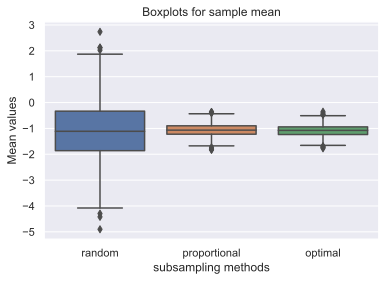

In [12]:
# Run plotting for boxplots
plot_boxplot(gp2)

In [13]:
# estimators(gp2)

We can observe that with equal standard deviations and different means, proprtional and optimal sampling give us significantly lower variance than random sampling.

**General population with DIFFERENT means and DIFFERENT STDs of strata**  
Distribution histogram:

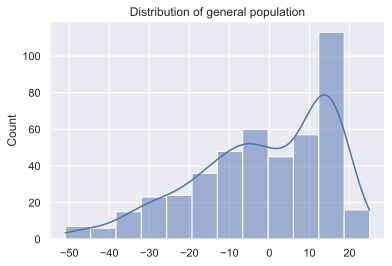

In [14]:
# Run plotting for density
plot_hist(gp3)

(Negatively) Skewed distribution.

Boxplots for sample mean:

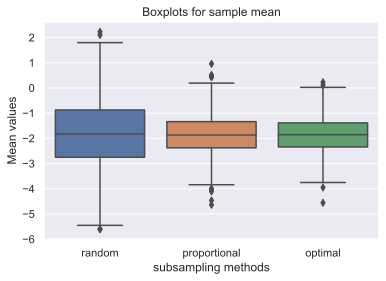

In [15]:
# Run plotting for boxplots
plot_boxplot(gp3)

In [16]:
# estimators(gp3)

In these case we can see that again random sampling is worse than the latter two methods, which are similar, however optimal sampling gives us the lowest variance.

With the experiments conducted and statistics estimated we can generate these <b>conclusions</b>: 

Optimal sampling aims to generate samples with lower sample mean variance, which means also shorter IQR, which we could observe on the charts. This advantage is to be seen mainly in case of different means and standard deviations, in case strata's means and stds, or just stds, are equal, there is no big difference between sampling methods in terms of variance.

# Task 2



### Part 1
Using [this criteria](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/#:~:text=For%20the%20Pearson%20correlation%2C%20an,linear%20relationship%20between%20the%20variables.&text=If%20both%20variables%20tend%20to,represents%20the%20correlation%20slopes%20upward.), check whether there is a correlation between a brain size and intelligence for a dataset consisted both of men and women objects. Also check it for men and women subsamples separately.


### Part 2
Using $Chi^2$ criteria check whether there is a statistical difference between men's and women's choice of auto.  (Features `Sex` и `PreferCar`)


You can download dataset using the following:

In [17]:
from bds_courseware import read_drive_dataset
from bds_courseware import HOMEWORK_DATASETS
brain_data = read_drive_dataset(*HOMEWORK_DATASETS['brain'])  # PART 1
cars_prefes_data = read_drive_dataset(*HOMEWORK_DATASETS['car_perfs'])  # PART 2

### Part 1 - Solution

Let's perform a simple EDA of our *brain_data* before we begin our task.

Number of cases: 40 <br>
Variable Names:
* 1. Gender: Male or Female
* 2. FSIQ: Full Scale IQ scores
* 3. VIQ: Verbal IQ scores
* 4. PIQ: Performance IQ scores
* 5. Weight: body weight in pounds
* 6. Height: height in inches
* 7. MRI_Count: total pixel Count from the 18 MRI scans

We consider *MRI_Count* as an index for brain size and *FSIQ* as main index for intelligence. 

In [18]:
brain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gender     40 non-null     object
 1   FSIQ       40 non-null     int64 
 2   VIQ        40 non-null     int64 
 3   PIQ        40 non-null     int64 
 4   Weight     40 non-null     object
 5   Height     40 non-null     object
 6   MRI_Count  40 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 2.3+ KB


First of all, human weight and height are classified as object type, which could be due to "hidden" missing values, one of which we can see below.

In [19]:
brain_data.head() # there are 3 "missing" values ("?") in the dataset (2x Weight and 1x Height)

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,Female,133,132,124,118,64.5,816932
1,Male,140,150,124,�,72.5,1001121
2,Male,139,123,150,143,73.3,1038437
3,Male,133,129,128,172,68.8,965353
4,Female,137,132,134,147,65.0,951545


There are only 3 missings and they're not a problem for us so far, so let's leave them for now. However, we're going to change the type of this features to numerical, as it should be.

In [20]:
brain_data["Weight"] = brain_data["Weight"].apply(pd.to_numeric, errors='coerce')
brain_data["Height"] = brain_data["Height"].apply(pd.to_numeric, errors='coerce')

In [21]:
brain_data.describe()

,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
count,40.000000,40.000000,40.00000,38.000000,39.000000,4.000000e+01
mean,113.450000,112.350000,111.02500,151.052632,68.525641,9.087550e+05
std,24.082071,23.616107,22.47105,23.478509,3.994649,7.228205e+04
min,77.000000,71.000000,72.00000,106.000000,62.000000,7.906190e+05
25%,89.750000,90.000000,88.25000,135.250000,66.000000,8.559185e+05
50%,116.500000,113.000000,115.00000,146.500000,68.000000,9.053990e+05
75%,135.500000,129.750000,128.00000,172.000000,70.500000,9.500780e+05
max,144.000000,150.000000,150.00000,192.000000,77.000000,1.079549e+06


As we are going to look at females/males separately, let's see if *Gender* variable is balanced.

[Text(0.5, 1.0, 'Distribution of Gender variable'), Text(0.5, 0, '')]

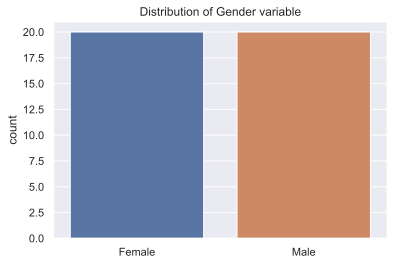

In [22]:
sns.countplot(x="Gender", data=brain_data).set(title='Distribution of Gender variable', xlabel="")

Luckily the data is splitted perfectly and we have equal subsamples. Let's now analyse whether human's body size affects brain size, generally and depending on gender.

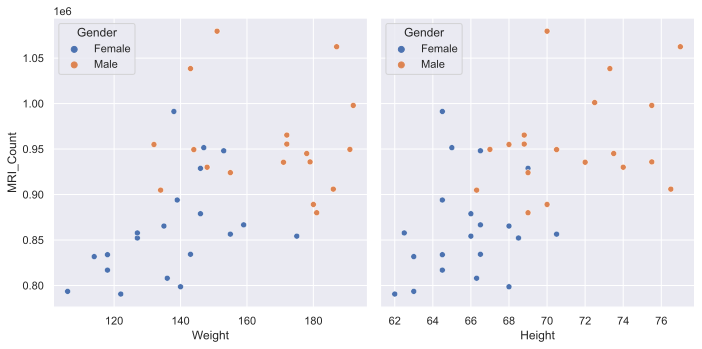

In [23]:
f, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
sns.scatterplot(x="Weight",y="MRI_Count", data=brain_data, hue="Gender", ax=axes[0])
sns.scatterplot(x="Height",y="MRI_Count", data=brain_data, hue="Gender", ax=axes[1])
plt.tight_layout()

In both cases we see a moderate positive relationship between variables in total, in case of *Weight* it is more visible for males and in case of *Height* - for females.<br>
Let's now focus on our IQ's variables. 

Text(101.45, 6, 'Mean: 113.45')

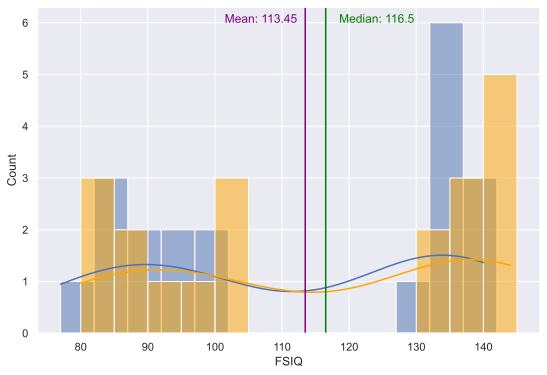

In [24]:
plt.figure(figsize=(9,6))
sns.histplot(x="FSIQ", data=brain_data[brain_data.Gender=="Female"], binwidth=5, kde=True)
sns.histplot(x="FSIQ", data=brain_data[brain_data.Gender=="Male"], binwidth=5, color='orange', kde=True)
plt.axvline(np.median(brain_data.FSIQ), color="green")
plt.text(2+np.median(brain_data.FSIQ),6, 'Median: ' +str(np.median(brain_data.FSIQ)), color="green")
plt.axvline(np.mean(brain_data.FSIQ), color="purple")
plt.text(np.mean(brain_data.FSIQ)-12,6, 'Mean: ' +str(np.mean(brain_data.FSIQ)), color="purple")

We can clearly see that our histogram is bimodal and shows the presence of two distincts clusters of our observations, no matter if we consider the whole sample, or men/women subsamples. 

Let's now conduct the correlation analysis given in the task.

**1. Examine the linear relationship between variables (Pearson)**

<AxesSubplot:xlabel='FSIQ', ylabel='MRI_Count'>

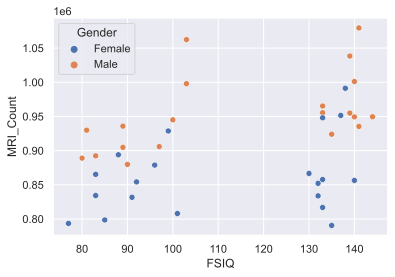

In [25]:
sns.scatterplot(x="FSIQ",y="MRI_Count", hue="Gender", data=brain_data)

We can see that in general, there is no relationship (linear) between those variables. However, when we split the data due to gender, we can observe a moderate positive relationship for males and no relationship (linear) for females.

Let's calculate the Pearson coefficient to verify our speculations. 

In [26]:
cor = brain_data[["FSIQ","MRI_Count"]].corr(method='pearson').iloc[0,1].round(4)
cor1 = brain_data[brain_data.Gender=="Male"][["FSIQ","MRI_Count"]].corr(method='pearson').iloc[0,1].round(4)
cor2 = brain_data[brain_data.Gender=="Female"][["FSIQ","MRI_Count"]].corr(method='pearson').iloc[0,1].round(4)
print('Male: ',cor1, ' Female: ',cor2, ' Total: ',cor)

Male:  0.4984  Female:  0.3257  Total:  0.3576


We can see that for male we indeed have a higher coefficient ~0.5 which is adequate for moderate positive linear relationship.

**2. Determine whether the correlation coefficient is significant**

To determine whether the correlation between variables is significant, we will compare the p-value to significance level ($\alpha=0.05$). It is a p-value for testing non-correlation. 

Let $\rho$ = Pearson correlation coefficient, then we have following hypothesis: <br>
$H_{0}:\rho=0$ <br>
$H_{1}:\rho\neq 0$

Luckily we have a function in *scipy.stats* calculating those p-values.
They will tells us whether the correlation coefficient is significantly different from 0. (A coefficient of 0 indicates that there is no linear relationship.)

* P-value ≤ $\alpha$: the correlation is statistically significant
(different from 0)
* P-value > $\alpha$: the correlation is not statistically significant
(we cannot conclude that the correlation is different from 0; there's no reason to reject $H_{0}$ hypothesis).


In [27]:
# male
pearsonr(brain_data.query('Gender=="Male"').FSIQ, brain_data.query('Gender=="Male"').MRI_Count)

(0.49836911041719256, 0.025319401349742674)

We can conclude that correlation coefficient for males is significant as our p-value is smaller than significance level.

In [28]:
# female
pearsonr(brain_data.query('Gender=="Female"').FSIQ, brain_data.query('Gender=="Female"').MRI_Count)

(0.3256967004963704, 0.1611157761890763)

On the contrary, we have no reason to believe that correlation coefficient for females differs from 0 (no reason to reject $H_{0}$ saying there's no linear relationship) as our p-value is much higher than significance level.

In [29]:
# total
pearsonr(brain_data.FSIQ, brain_data.MRI_Count)

(0.35764096936905665, 0.02346891262690166)

In total we have a little less clear situation, because the coefficient tells us there's no relationship (linear), but p-value says this correlation is statistically significant. Hence, there is inconclusive evidence about the significance of the association between those variables.

**3. Examine the monotonic relationship between variables (Spearman)**

We will use the Spearman correlation coefficient to examine the strength and direction of the monotonic relationship between two continuous or ordinal variables. Let's look once again on our data.

<AxesSubplot:xlabel='FSIQ', ylabel='MRI_Count'>

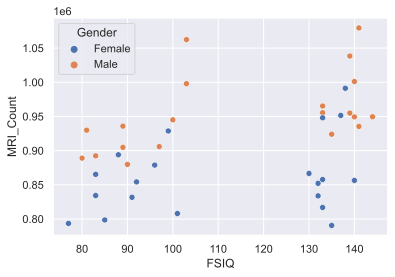

In [30]:
sns.scatterplot(x="FSIQ",y="MRI_Count", hue="Gender", data=brain_data)

There's no characteristic relationship to be seen, even non-linear, so let's look into values of coefficients and p-values.

In [31]:
# male
spearmanr(brain_data.query('Gender=="Male"').FSIQ, brain_data.query('Gender=="Male"').MRI_Count)

SpearmanrResult(correlation=0.6224582598536048, pvalue=0.0033787319187759068)

There's a positive correlation between those variables for males, and it's a significant one, due to p-value smaller than 0.05.

In [32]:
# female
spearmanr(brain_data.query('Gender=="Female"').FSIQ, brain_data.query('Gender=="Female"').MRI_Count)

SpearmanrResult(correlation=0.2991718270724953, pvalue=0.20006072686083715)

No relationship for females, and also it's an insignificant correlation.

In [33]:
# total
spearmanr(brain_data.FSIQ, brain_data.MRI_Count)

SpearmanrResult(correlation=0.47214191583899207, pvalue=0.0020984777996441214)

The coefficient is not really high, it could indicate a moderate positive relationship, but we also see that it's a significant correlation, so we can conclude there's a moderate positive relationship (mainly due to relationship for males).

**Conclusion**

There is a correlation between a brain size and intelligence for a dataset consisted of men and there is no correlation for females; generally for both there's a moderate positive relationship.

Additional: it could be interesting to analyse the data in two separate clusters defined by FSIQ value, not by gender. Or to scale the brain size with height/weight and then analyse the data.

### Part 2 - Solution

Let's performe a simple EDA on our *cars_prefes_data* before we begin our task.


In [34]:
cars_prefes_data.head()

,ID,Age,Sex,LicYr,LicMth,ActCar,Kids5,Kids6,PreferCar,Car15K,...,Reliable,Perform,Fuel,Safety,AC/PS,Park,Room,Doors,Prestige,Colour
0,110,18,2,0,2,3,2,2,2,2,...,4,3,3,3,3,3,3,3,3,2
1,111,25,1,8,0,1,2,2,1,1,...,4,4,4,4,3,4,4,2,3,3
2,112,63,2,46,0,3,2,2,3,2,...,3,3,3,3,3,3,3,3,3,3
3,113,51,1,35,0,3,2,2,2,2,...,3,3,3,4,3,3,3,3,1,3
4,114,19,1,2,0,2,2,2,2,1,...,3,4,3,3,2,3,3,2,3,3


In [35]:
cars_prefes_data.info() # 300 records, 22 columns, most of which probably ordinal, given int type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         300 non-null    int64
 1   Age        300 non-null    int64
 2   Sex        300 non-null    int64
 3   LicYr      300 non-null    int64
 4   LicMth     300 non-null    int64
 5   ActCar     300 non-null    int64
 6   Kids5      300 non-null    int64
 7   Kids6      300 non-null    int64
 8   PreferCar  300 non-null    int64
 9   Car15K     300 non-null    int64
 10  Reason     300 non-null    int64
 11  Cost       300 non-null    int64
 12  Reliable   300 non-null    int64
 13  Perform    300 non-null    int64
 14  Fuel       300 non-null    int64
 15  Safety     300 non-null    int64
 16  AC/PS      300 non-null    int64
 17  Park       300 non-null    int64
 18  Room       300 non-null    int64
 19  Doors      300 non-null    int64
 20  Prestige   300 non-null    int64
 21  Colour     300 n

In [36]:
cars_prefes_data.describe()

,ID,Age,Sex,LicYr,LicMth,ActCar,Kids5,Kids6,PreferCar,Car15K,...,Reliable,Perform,Fuel,Safety,AC/PS,Park,Room,Doors,Prestige,Colour
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,209.986667,34.123333,1.500000,15.240000,0.620000,2.000000,1.903333,1.736667,2.17000,1.536667,...,3.830000,3.336667,3.293333,3.576667,2.876667,2.716667,2.990000,2.546667,2.100000,2.186667
std,108.131562,15.344695,0.500835,14.424376,1.995547,0.817861,0.295997,0.441178,0.86618,0.499487,...,0.393637,0.681815,0.664903,0.631494,1.002400,0.905052,0.738275,1.008901,0.897786,0.928095
min,1.000000,18.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,117.750000,21.000000,1.000000,3.000000,0.000000,1.000000,2.000000,1.000000,2.00000,1.000000,...,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000
50%,206.500000,27.000000,1.500000,9.000000,0.000000,2.000000,2.000000,2.000000,2.00000,2.000000,...,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000
75%,307.250000,46.000000,2.000000,26.000000,0.000000,3.000000,2.000000,2.000000,3.00000,2.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,393.000000,75.000000,2.000000,57.000000,11.000000,3.000000,2.000000,2.000000,4.00000,2.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


If scale 1-4 means priority/importance of given feature, we can see that *Reliable*, *Safety*, *Fuel*, *Perform* are among most important ones.

<AxesSubplot:xlabel='Age', ylabel='Count'>

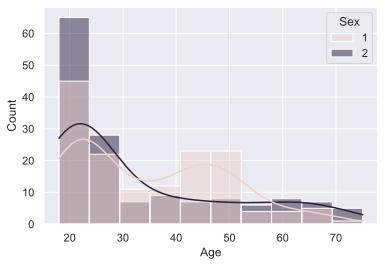

In [37]:
sns.histplot(x='Age', hue='Sex', data=cars_prefes_data, kde=True)

We can see that among men respondents dominate 18-30 age group, whereas among women same group and additionaly 40-50 range.

Let's look at the variables of our interest (*Sex*, *PreferCar*):

Text(0.5, 1.0, 'Distribution of PreferCar vs Sex')

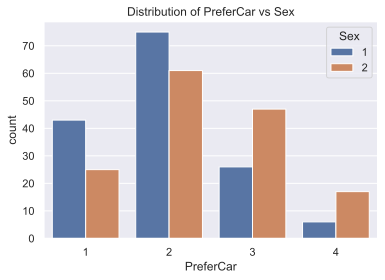

In [38]:
sns.countplot(x="PreferCar", hue="Sex", data=cars_prefes_data).set_title('Distribution of PreferCar vs Sex')

As we can see, car type 1 and 2 are more preferable for females, while types 3 and 4 - for males. We can therefore expect there's a dependency between those two features. Let's now see whether color anf safety matters for men and women.

#### Chi-squared test

In order to determine whether there is a statistical difference between men's and women's choice of car, we will conduct Pearson’s chi-squared test for independence between categorical variables. If there's no difference - features are independent.

$H_{0}:$ features are independent <br>
$H_{1}:$ features are dependent

Let $\alpha$ = 0.05. <br>
p-value $\leq \alpha$ : significant result, reject null hypothesis $H_{0}$ (dependent) <br>
p-value $> \alpha$: not significant result, fail to reject null hypothesis  $H_{0}$ (independent)

We begin with summarizing our variables in a contingency table (crosstab).

In [39]:
# contingency table
table = pd.crosstab(cars_prefes_data['Sex'], cars_prefes_data['PreferCar']) 
table

PreferCar,1,2,3,4
Sex,,,,
1,43,75,26,6
2,25,61,47,17


<AxesSubplot:xlabel='PreferCar', ylabel='Sex'>

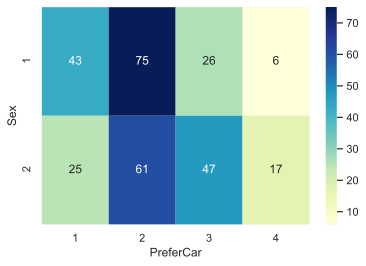

In [40]:
sns.heatmap(table, annot=True, cmap="YlGnBu")

We can see that the values for men and women differ so we can expect dependency. However, let's conduct a formal test to verify our assumptions.

In [41]:
# chi^2 test
# stat: test statistic
# p: p-value of the test
# dof: degrees of freedom
# expected: expected frequencies, based on the marginal sums of the table
stat, p, dof, expected = chi2_contingency(table) 

In [42]:
expected

array([[34. , 68. , 36.5, 11.5],
       [34. , 68. , 36.5, 11.5]])

Our frequencies significantly differ from the expected ones, so we can expect $H_{0}$ rejection.

In [43]:
# critical value
prob = 0.95 # we set significance level alpha = 0.05
critical = chi2.ppf(prob, dof)
critical

7.814727903251179

In [44]:
print('Statistic: ', stat,' P-value: ', p)

Statistic:  17.507847808569526  P-value:  0.0005555699275518034


As we can see, the statistic exceeds critical value, and p-value is much smaller than significance level which means we reject our null hypothesis about features' independency. Our conclusion is that *Sex* and *PreferCar* are dependent so there is a statistical difference between men's and women's choice of car.

# Task 3

You can find and download a dataset there:
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016


1) For any country (you are free to choose any of the presented) 
 *  Visualize a feature **suicides_no** considering other features: **sex**, **age** (or **generation**) and year;
 *  Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

2) For 2016: divide countries into 3-4 groups according to the values of the **gdp_per_capita** feature (use statistical characteristics to determine how to divide the data into groups), check if the suicides / 100k pop indicator differs in these groups. Do not forget that for each country you have several values and they need to be aggregated or checked for each group separately.

In [45]:
data = pd.read_csv("master.csv")

In [46]:
data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


We can see we have some common indexes in our data, and also we have suicides number for different age groups, generations, sexes and years.

### For one country

In [48]:
data_nz = data.query('country=="New Zealand"') # choosing New Zealand
data_nz.shape

(348, 12)

In [49]:
data_nz.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,348.000000,348.000000,348.000000,348.000000,108.000000,348.000000
mean,1999.000000,41.330460,296236.867816,14.391724,0.875667,22279.482759
std,8.378647,38.937658,129681.785921,11.898441,0.038327,10360.946851
min,1985.000000,0.000000,46900.000000,0.000000,0.805000,8246.000000
25%,1992.000000,12.000000,261500.000000,5.267500,0.855000,14725.000000
50%,1999.000000,25.000000,283470.000000,9.220000,0.895000,18208.000000
75%,2006.000000,66.000000,312745.000000,23.917500,0.907000,29803.000000
max,2013.000000,155.000000,635970.000000,54.790000,0.911000,46198.000000


In [50]:
data.generation.value_counts()

Generation X       6408
Silent             6364
Millenials         5844
Boomers            4990
G.I. Generation    2744
Generation Z       1470
Name: generation, dtype: int64

**Visualisations**

Text(0.5, 1.0, 'Distribution of suicides_no vs sex')

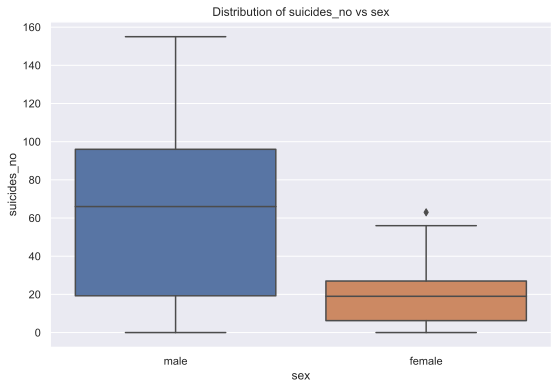

In [51]:
# suicides_no vs sex
plt.figure(figsize=(9,6))
sns.boxplot(x='sex', y='suicides_no', data=data_nz).set_title('Distribution of suicides_no vs sex')

We can see that there is far less female suicides than male, i.e. female one outlier is smaller (meaning suicides number) than male's median and female median is on the level of male Q1.

Text(0.5, 1.0, 'Distribution of suicides_no vs age')

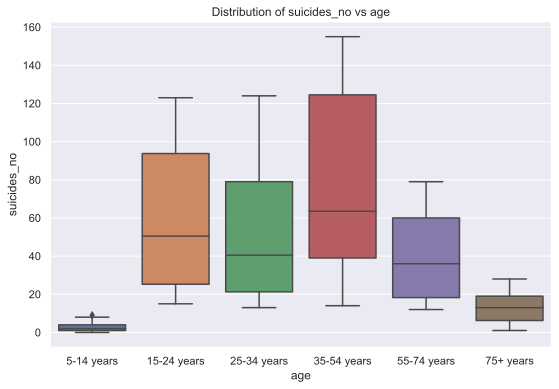

In [52]:
# suicides_no vs age
plt.figure(figsize=(9,6))
sns.boxplot(x='age', y='suicides_no', data=data_nz, 
            order=['5-14 years','15-24 years','25-34 years','35-54 years','55-74 years','75+ years']
           ).set_title('Distribution of suicides_no vs age')

In terms of age groups, most suicides happen in 35-54 years group, however, we can also see that the groups do not cover same years range (we have 10, 10, 10, 20, 20, something around 10-20 probably). Generally, distinct majority of suicides happen in 15-54 age range.

Text(0.5, 1.0, 'Distribution of suicides_no vs year and sex')

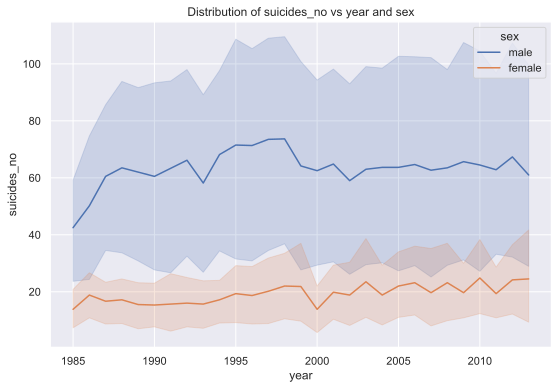

In [53]:
# suicides vs sex
temp = data_nz[["year","suicides_no","sex"]].groupby(['year', 'sex']).sum()
plt.figure(figsize=(9,6))
sns.lineplot(x='year', y='suicides_no', hue='sex', data=data_nz).set_title('Distribution of suicides_no vs year and sex')

There a huge difference between males and females, as we already know, and through the years there are two "anomalies": an increase, particulary for males, in years 1985-87, and a drop at the end of 90's. Since 2000 the situation is quite stable, but in general, sum of male suicides is more dynamic than females.

<AxesSubplot:xlabel='age', ylabel='suicides_no'>

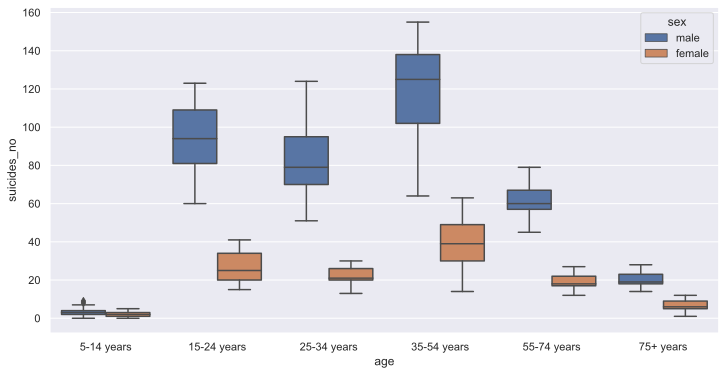

In [54]:
# sex, age and suicides 
plt.figure(figsize=(12,6))
sns.boxplot(x="age", y="suicides_no",
                hue="sex",order=['5-14 years','15-24 years','25-34 years','35-54 years','55-74 years','75+ years'],
                data=data_nz)

We can observe that in case of males there are bigger differences among age groups than in case of females.

Let's now focus on the second part of the task - checking if there is statistical difference for suicide number between men and women. Given the previous analysis, we can expect it is true.

<AxesSubplot:xlabel='suicides_no', ylabel='Count'>

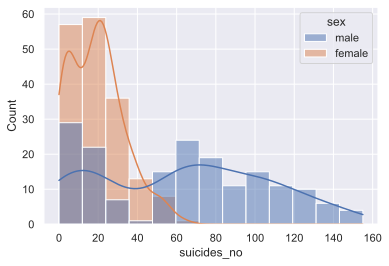

In [55]:
sns.histplot(x="suicides_no", data=data_nz, kde=True, bins=13, hue="sex")

We can clearly see that those two distributions are totally different, so once again our belief is confirmed. Let's test it. We cannot use Chi-squared test here, because we're not testing two categorical variables, so we will check general distribution equality with Kolmogorov–Smirnov test.

In [56]:
d1 = data_nz.query('sex=="male"')["suicides_no"]
d2 = data_nz.query('sex=="female"')["suicides_no"]

# K-S - general
stat, p = kstest(d1,d2, alternative='two-sided')
print('K-S | Statistic: ', stat, ' P-value: ', p)

K-S | Statistic:  0.6149425287356322  P-value:  4.803816876936327e-31


P-value is really small, practically equals 0, so we reject our null hypothesis about equal distributions of suicides number for men and women. However, from the test itself we cannot tell with sex is more prone to suicide. We can conduct additional analysis, as we did before the test, which tells us that probably men suicides in New Zealand happen more often. However, we should also check whether New Zealand's population is balanced, if there are much more men, it is normal that there are much more men suicides. That's why a coefficient - suicides balanced by population for each sex - would be more informative.

### Data from 2016

In [57]:
data_2016 = data.query('year==2016')

In [58]:
data_2016.shape # 160 records from 2016

(160, 12)

We will add additional column to our data in order to group the countries according to GDP per capita. The split is based on gdp_per_capita feature's quartiles.



In [59]:
data_2016["gdp_per_capita ($)"].quantile([0.25,0.5,0.75,1]) # gdp per capita quartiles to divide by

0.25    10432.5
0.50    14595.0
0.75    47259.0
1.00    64708.0
Name: gdp_per_capita ($), dtype: float64

In [60]:
data_2016["gdp_quartile"] = pd.qcut(data_2016["gdp_per_capita ($)"], 4, labels=["Q1","Q2","Q3","Q4"])
data_2016.head() 

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation,gdp_quartile
1248,Armenia,2016,male,75+ years,12,61956,19.37,Armenia2016,NaN,"10,546,135,160",3788,Silent,Q1
1249,Armenia,2016,male,55-74 years,16,237813,6.73,Armenia2016,NaN,"10,546,135,160",3788,Boomers,Q1
1250,Armenia,2016,male,35-54 years,16,350633,4.56,Armenia2016,NaN,"10,546,135,160",3788,Generation X,Q1
1251,Armenia,2016,male,15-24 years,5,202220,2.47,Armenia2016,NaN,"10,546,135,160",3788,Millenials,Q1
1252,Armenia,2016,female,75+ years,2,102414,1.95,Armenia2016,NaN,"10,546,135,160",3788,Silent,Q1


In [61]:
data_2016['HDI for year'].isna().sum() # HDI variable is NaN for entire 2016 - carries no information so we drop it

160

We also drop year column - we selected one year so we don't need it, and country-year as well.

In [62]:
data_2016 = data_2016.drop(['HDI for year','year','country-year'], axis=1)
data_2016.head()

,country,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),generation,gdp_quartile
1248,Armenia,male,75+ years,12,61956,19.37,"10,546,135,160",3788,Silent,Q1
1249,Armenia,male,55-74 years,16,237813,6.73,"10,546,135,160",3788,Boomers,Q1
1250,Armenia,male,35-54 years,16,350633,4.56,"10,546,135,160",3788,Generation X,Q1
1251,Armenia,male,15-24 years,5,202220,2.47,"10,546,135,160",3788,Millenials,Q1
1252,Armenia,female,75+ years,2,102414,1.95,"10,546,135,160",3788,Silent,Q1


We already performed some EDA of this dataset, but for one country, so let's do some more.

<AxesSubplot:xlabel='suicides_no', ylabel='Count'>

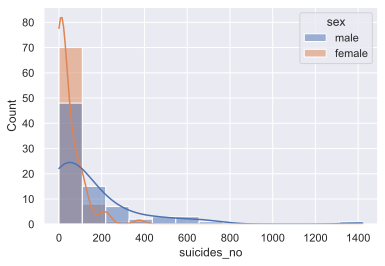

In [63]:
sns.histplot(x="suicides_no", data=data_2016, kde=True, bins=13, hue="sex")

<AxesSubplot:xlabel='generation', ylabel='suicides_no'>

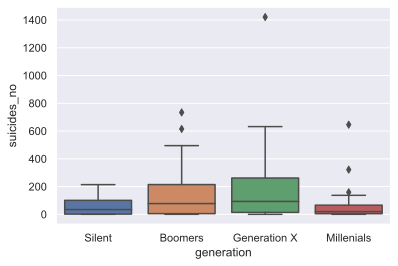

In [64]:
sns.boxplot(x="generation", y="suicides_no", data=data_2016)

Analysing plots above, we can clearly see that we have an anomaly among males - let's check it.

In [65]:
data_2016.query('suicides_no > 1200')

,country,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),generation,gdp_quartile
25303,Thailand,male,35-54 years,1421,10084647,14.09,"411,755,164,833",6713,Generation X,Q1


Suicides/100k pop looks normal, so better focus on this feature.

**Dividing countries into groups**

In [66]:
grouped = dict(tuple(data_2016.groupby('gdp_quartile')))

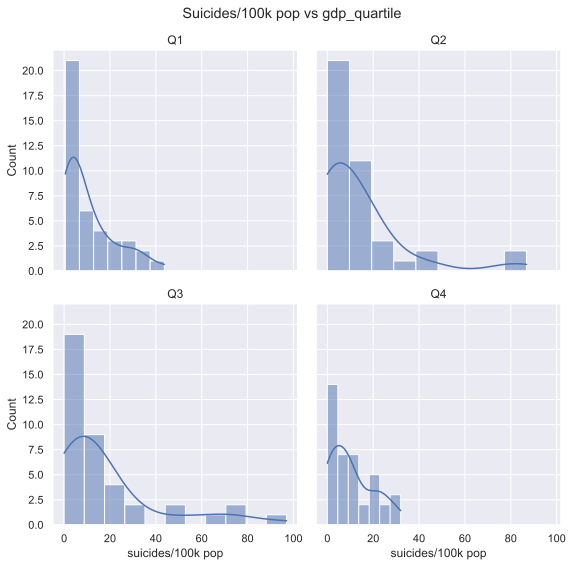

In [67]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
nr=1
for i in range(0, 2):
    for j in range(0, 2):
        name = "Q"+str(nr)
        sns.histplot(data=grouped[name], x="suicides/100k pop", kde=True, ax=axes[i,j]).set_title(name)
        nr+=1
plt.suptitle('Suicides/100k pop vs gdp_quartile')
plt.tight_layout()

We can see that all those distributions are positively skewed, however two of them have long tails. It means we will not be able to perform ANOVA test to check means equality, because it demands normal distribution, but we can conduct Kruskal-Wallis test.

In [68]:
df1, df2, df3, df4 = grouped["Q1"], grouped["Q2"], grouped["Q3"], grouped["Q4"]

# Kruskal
var = "suicides/100k pop"
stat, p = kruskal(df1[[var]],df2[[var]],df3[[var]],df4[[var]])
print('Statistic: ', stat, ' P-value: ', p)

Statistic:  3.4304712199804563  P-value:  0.3298923595305942


The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. Given the p-value we can conclude that there's no reason to reject this thesis. Let's see those medians to check whether they're truly equal.

In [69]:
data_2016.groupby('gdp_quartile')['suicides/100k pop'].median()

gdp_quartile
Q1    5.620
Q2    8.345
Q3    9.950
Q4    8.865
Name: suicides/100k pop, dtype: float64

Three medians are quite similar indeed, but the first one is a bit smaller. 

Let's try another option. Within each group we will aggregate the indicator by country, and then by group.

In [70]:
m1 = df1.groupby(['country'])[var].median().reset_index()
m2 = df2.groupby(['country'])[var].median().reset_index()
m3 = df3.groupby(['country'])[var].median().reset_index()
m4 = df4.groupby(['country'])[var].median().reset_index()

In [71]:
medians = [np.median(m1[var]), np.median(m2[var]), np.median(m3[var]), np.median(m4[var])]
medians

[6.3775, 10.705, 11.2225, 10.2725]

The difference is even bigger, meaning our test is not very good in this case, because this one median surely differs from the rest. There's also not a good practice to test them in pairs.